Okay first thing's first, let's get the prerequisites installed. Aerosandbox will provide the simulation environment, and baseline will include gym and the related requirements for training a model to optimize within that simulation.

🚨 Using Python 3.9.6 (3.11.x has compatability issues with AeroSandbox)

In [1]:
# Install a pip package in the current Jupyter kernel 🚨RUN THIS CELL ONCE FOR YOUR ENVIRONMENT
import sys
!{sys.executable} -m pip install 'aerosandbox[full]'
!{sys.executable} -m pip install "gymnasium[all]"
!{sys.executable} -m pip install 'stable_baselines3[extra]'
!{sys.executable} -m pip install 'tensorboard'

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
  Using cached Shimmy-0.2.1-py3-none-any.whl (25 kB)
  Attempting uninstall: shimmy
    Found existing installation: Shimmy 1.1.0
    Uninstalling Shimmy-1.1.0:
      Successfully uninstalled Shimmy-1.1.0
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
  Using cached Shimmy-1.1.0-py3-none-any.whl (37 kB)
  Attempting uninstall: shimmy
    Found existing installation: Shimmy 0.2.1
    Uninstalling Shimmy-0.2.1:
      Successfully uninstalled Shimmy-0.2.1
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pi

Alright let's set up the custom environment

First let's instantiate a plane with basic geometry:

In [2]:
#Helper
import numpy as np
def flatten_list(nested_item):
    flattened = []
    
    if isinstance(nested_item, (list, np.ndarray)):
        for item in nested_item:
            flattened.extend(flatten_list(item))
    else:
        flattened.append(nested_item)
    
    return flattened

In [3]:


import aerosandbox as asb
import aerosandbox.numpy as np
import gymnasium as gym
from gymnasium import spaces
import numpy as np
	
class AeroEnv(gym.Env):

	# construct and save self.airplane from self.xsecs
	def constructAirplane(self):
		self.airplane = asb.Airplane(
			name="TestPlane",
			xyz_ref=[0, 0, 0],        # Reference for moments
			wings=[asb.Wing(
					name="Wing",    
					symmetric=True,
					xsecs=self.xsecs
				)],
		)
	
	#attempting to constraint reward
	def getReward(self):
		lift = self.aero["L"]
		drag = self.aero["D"]
		reward = lift/drag
		if(drag < 0 or lift < 0):
			reward = -100

		return reward

	# construct and safe self.vlm()
	def runAero(self):
		self.vlm = asb.VortexLatticeMethod(
			airplane=self.airplane,
			op_point=asb.OperatingPoint(
				velocity=22.22,  # 80kph
				alpha=0,  # degree
			),
			
		)
		self.vlm.run_symmetric = True
		self.aero = self.vlm.run()
		
	# get observations from current self.xsecs
	def get_observation_vector(self):
		obs = []
		for xsec in self.xsecs:
			# xyz_le is a list of three values
			obs.extend(xsec.xyz_le)
			
			# chord and twist are single values
			obs.append(xsec.chord)
			obs.append(xsec.twist)

			# KulfanAirfoil attributes
			# Both upper_weights and lower_weights are numpy arrays
			obs.extend(xsec.airfoil.upper_weights.tolist())
			obs.extend(xsec.airfoil.lower_weights.tolist())

			# leading_edge_weight, N1, and N2 are single values
			obs.append(xsec.airfoil.leading_edge_weight)
			obs.append(xsec.airfoil.N1)
			obs.append(xsec.airfoil.N2)
		# Append aerodynamics output at the end
		# - 'F_g' : an [x, y, z] list of forces in geometry axes [N]
		# - 'F_b' : an [x, y, z] list of forces in body axes [N]
		# - 'F_w' : an [x, y, z] list of forces in wind axes [N]
		# - 'M_g' : an [x, y, z] list of moments about geometry axes [Nm]
		# - 'M_b' : an [x, y, z] list of moments about body axes [Nm]
		# - 'M_w' : an [x, y, z] list of moments about wind axes [Nm]
		# - 'L' : the lift force [N]. Definitionally, this is in wind axes.
		# - 'Y' : the side force [N]. This is in wind axes.
		# - 'D' : the drag force [N]. Definitionally, this is in wind axes.
		# - 'l_b', the rolling moment, in body axes [Nm]. Positive is roll-right.
		# - 'm_b', the pitching moment, in body axes [Nm]. Positive is pitch-up.
		# - 'n_b', the yawing moment, in body axes [Nm]. Positive is nose-right.
		# - 'CL', the lift coefficient [-]. Definitionally, this is in wind axes.
		# - 'CY', the sideforce coefficient [-]. This is in wind axes.
		# - 'CD', the drag coefficient [-]. Definitionally, this is in wind axes.
		# - 'Cl', the rolling coefficient [-], in body axes
		# - 'Cm', the pitching coefficient [-], in body axes
		# - 'Cn', the yawing coefficient [-], in body axes
		drag = self.aero["D"]
		lift = self.aero["L"]
		drag = np.tanh((drag-50)/50)
		lift = np.tanh((lift-50)/50)
		obs.append(lift)
		obs.append(drag)
		return np.array(obs, dtype=np.float32)
	
	def __init__(self, 
			  # === Key Parameters ===
			  episodeSteps,
			  kulfanWeightResolution, 	#How many kulfan weights per XSec? More = more intricate designs. Something like 5-8 should be enough...
			  numChords, 				#How many independently controlled foils along length of wing 

			  # === Initial Values ===
			  initialYSpacing, 			#Initial spacing of the cross sections
			  initialChordLength, 		#Initial length from front to back of each cross section in wing
			  initialUpperKulfan, 		#Upper kulfan weight initial values (controls curvature of top of wing)
			  initialLowerKulfan, 		#Lower Kulfan weight initial values (controls curvature of bottom of wing)
			  initialLEW, 				#Leading edge weight initial values
			  initialN1, 				#Initial N1 value (forward shift of wing curve shape)
			  initialN2, 				#Initial N2 value (backwards shift of wing curve shape)
			  
			  # === Changing Values ===
			  dX_bounds, 				#How much to allow shift of each cross section per time step in forward/backwards direction
			  dY_bounds, 				#How much to allow shift of each cross section per time step in left/right direction (stubbier wings)
			  dZ_bounds, 				#How much to allow shift of each cross section per time step in up/down direction (wingtips?)
			  dChord_bounds, 			#How much to allow each cross section to change in length per timestep (wider wings? front-back length)
			  dTwist_bounds, 			#How much (in DEGREES) to allow rotation of each cross section per timestep about leading edge
			  KT_bounds, 				#Min/max upper kulfan weights (should be 0,>0)
			  KB_bounds, 				#Max lower kulfan weights (should be <0,0 unless you want to create gaps on bottom of wing that arc up)
			  N_bounds, 				#Bounds of either N value (1, ?)
			  LEW_bounds, 				#Bounds of leading edge weight (??? TODO: Learn what the fuck this does lmao. Experiment)
		):
		super(AeroEnv, self).__init__() #Initialize gym enviro
		self.numChords = numChords
		self.kulfanWeightResolution = kulfanWeightResolution
		
		# Lower and upper bounds for each of the parameters
		low = np.array([dX_bounds[0], dY_bounds[0], dZ_bounds[0], dChord_bounds[0], dTwist_bounds[0]] + [KT_bounds[0]]*kulfanWeightResolution + [KB_bounds[0]]*kulfanWeightResolution + [N_bounds[0], N_bounds[0], LEW_bounds[0]], dtype=np.float32)
		high = np.array([dX_bounds[1], dY_bounds[1], dZ_bounds[1], dChord_bounds[1], dTwist_bounds[1]] + [KT_bounds[1]]*kulfanWeightResolution + [KB_bounds[1]]*kulfanWeightResolution + [N_bounds[1], N_bounds[1], LEW_bounds[1]], dtype=np.float32)
		self.vectorLengthPerXSec = len(low)
		# Creates a much bigger vector, action bounds PER cross section.
		oLow = low.copy()
		oHigh = high.copy()
		low = np.tile(low, numChords) 
		high = np.tile(high, numChords)

		# === Establish bounds for leading edges === 
		oLow[0]=oLow[0]*episodeSteps + 0 # 0 here is the initial value min
		oLow[1]=oLow[1]*episodeSteps + 0 # 0 here is the initial value min
		oLow[2]=oLow[2]*episodeSteps + 0 # 0 here is the initial value min

		oHigh[0]=oHigh[0]*episodeSteps + 0 # 0 here is the initial value max
		oHigh[1]=oHigh[1]*episodeSteps + numChords*initialYSpacing # initial value max is gonna be the farthest chord out
		oHigh[2]=oHigh[2]*episodeSteps + 0 # 0 here is the initial value max

		# === Establish bounds for CHORD and TWIST === 
		oLow[3]=oLow[3]*episodeSteps + initialChordLength 
		oLow[4]=oLow[4]*episodeSteps + 0 

		oHigh[3]=oHigh[3]*episodeSteps + initialChordLength
		oHigh[4]=oHigh[4]*episodeSteps + 0

		# === Establish KT / KB weight bounds, N bounds, LEW bounds ===
		# No need because absolute value, so bounds are same as action bounds

		oLow = np.tile(oLow, numChords) 
		oHigh = np.tile(oHigh, numChords)

		# === Establish Aerodynamic Bounds (AFTER tiling because not 1 per chord) ===
		oLow = np.append(oLow, [-1, -1]) #Lift, Drag: I intend to use tanH
		oHigh = np.append(oHigh, [1, 1]) #Lift, Drag: I intend to use tanH		

		self.observation_space = spaces.Box(low=oLow, high=oHigh, dtype=np.float32) #there are 18 additional values provided by vlm.run(), but Im just using 2, Lift and Drag
		self.action_space = spaces.Box(low=low, high=high, dtype=np.float32)
		

		# Initial values for cross sections
		self.init_xyz_le = [[0, i*initialYSpacing, 0] for i in range(self.numChords)]
		self.init_chord = [initialChordLength] * self.numChords  														
		self.init_twist = [0] * self.numChords  														
		self.init_upper_weights = [np.array([initialUpperKulfan] * self.kulfanWeightResolution,np.float32) for _ in range(self.numChords)]
		self.init_lower_weights = [np.array([initialLowerKulfan] * self.kulfanWeightResolution,np.float32) for _ in range(self.numChords)]
		self.init_leading_edge_weight = [initialLEW] * self.numChords  										
		self.init_N1 = [initialN1] * self.numChords 															
		self.init_N2 = [initialN2] * self.numChords

		self.xsecs = [asb.WingXSec(
			xyz_le=self.init_xyz_le[i],
			chord=self.init_chord[i],
			twist=self.init_twist[i],
			airfoil=asb.KulfanAirfoil(
				upper_weights=self.init_upper_weights[i],
				lower_weights=self.init_lower_weights[i],
				leading_edge_weight=self.init_leading_edge_weight[i],
				N1=self.init_N1[i],
				N2=self.init_N2[i]
			)
		) for i in range(self.numChords)]
		self.constructAirplane()
		
	def step(self, action):
		for i in range(self.numChords):
			idx = i * self.vectorLengthPerXSec

			# Apply dX, dY, dZ
			newXYZ_le = [
				self.xsecs[i].xyz_le[0] + action[idx], 		#x + dx
				self.xsecs[i].xyz_le[1] + action[idx + 1],	#y + dy
				self.xsecs[i].xyz_le[2] + action[idx + 2]	#z + dz
			]
			# Apply dChord, dTwist
			newChord = self.xsecs[i].chord + action[idx + 3] #chord + dchord
			newTwist = self.xsecs[i].twist + action[idx + 4]

			# Set KB, KT 
			newUpper_weights = np.array([action[idx + 5 + j] for j in range(self.kulfanWeightResolution)], np.float32)
			newLower_weights = np.array([action[idx + 5+self.kulfanWeightResolution + j] for j in range(self.kulfanWeightResolution)], np.float32)
			
			# Set LEW, N1, N2
			newLeading_edge_weight = action[idx + 5+2*self.kulfanWeightResolution] 	# LEW = action's LEW
			newN1 = action[idx + 6+2*self.kulfanWeightResolution] 					# N1 = action's N1
			newN2 = action[idx + 7+2*self.kulfanWeightResolution]					# N2 = action's N2

			self.xsecs[i] = asb.WingXSec(
				xyz_le= ([0,0,0] if i == 0 else newXYZ_le),
				chord=newChord,
				twist=newTwist,
				airfoil=asb.KulfanAirfoil(
					leading_edge_weight=newLeading_edge_weight,
					lower_weights=newLower_weights,
					upper_weights=newUpper_weights,
					N1=newN1,
					N2=newN2
				)
			)

		self.constructAirplane()
		self.runAero()
		
		obs = self.get_observation_vector()				# observation (ObsType): An element of the environment's observation_space as the next observation due to the agent actions.
		reward = self.getReward()						# reward (SupportsFloat): The reward as a result of taking the action.
		terminated = bool(reward >= 90) 				# terminated (bool): Whether the agent reaches the terminal state (as defined under the MDP of the task)
		truncated = bool(reward >= 90)	 				# truncated (bool): Whether the truncation condition outside the scope of the MDP is satisfied.
		info = {"lift": self.aero["L"], "drag": self.aero["L"]}	# info (dict): Contains auxiliary diagnostic information (helpful for debugging, learning, and logging).
		
		return obs, reward, terminated, truncated, info 
    
	def reset(self, seed=123):
		super().reset(seed=seed)
		# Reinitialize wing sections to their initial states
		self.xsecs = [asb.WingXSec(
			xyz_le=self.init_xyz_le[i],
			chord=self.init_chord[i],
			twist=self.init_twist[i],
			airfoil=asb.KulfanAirfoil(
				upper_weights=self.init_upper_weights[i],
				lower_weights=self.init_lower_weights[i],
				leading_edge_weight=self.init_leading_edge_weight[i],
				N1=self.init_N1[i],
				N2=self.init_N2[i]
			)
		) for i in range(self.numChords)]

		self.constructAirplane()
		self.runAero()
		
		liftCoeff = self.aero["CL"]
		dragCoeff = self.aero["CD"]

		obs = self.get_observation_vector()
		info = {"lift": liftCoeff, "drag": dragCoeff} 
		return obs, info
	
	def render(self):
		self.runAero()
		self.vlm.draw()
		print(self.aero)
		# self.airplane.draw_three_view()
		# self.vlm.draw()
	
	def close (self):
		...

In [4]:
# ##SanityCheck
# env = AeroEnv(
#     episodeSteps=40,
#     numChords=5, 
# 	initialYSpacing=.1, 
# 	initialChordLength=1, 
# 	initialUpperKulfan=2, 
# 	initialLowerKulfan=-2, 
# 	initialLEW=0, 
# 	initialN1=2, 
# 	initialN2=1, 
#     dX_bounds = (-0.05, 0.05),
# 	dY_bounds = (0.0, 0.2),
# 	dZ_bounds = (-0.05, 0.05),
# 	dChord_bounds = (0, 0.2),
# 	dTwist_bounds = (0, 0),
# 	KT_bounds = (-0.5, 2),
# 	KB_bounds = (-1, 0.5),
# 	N_bounds = (1, 4),
# 	LEW_bounds = (0, 1),
# 	kulfanWeightResolution = 7)

# obs = env.reset()
# random_action = env.action_space.sample()
# obs, reward, terminated, truncated, info = env.step(random_action)
# random_action = env.action_space.sample()
# obs, reward, terminated, truncated, info = env.step(random_action)
# random_action = env.action_space.sample()
# obs, reward, terminated, truncated, info = env.step(random_action)



/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


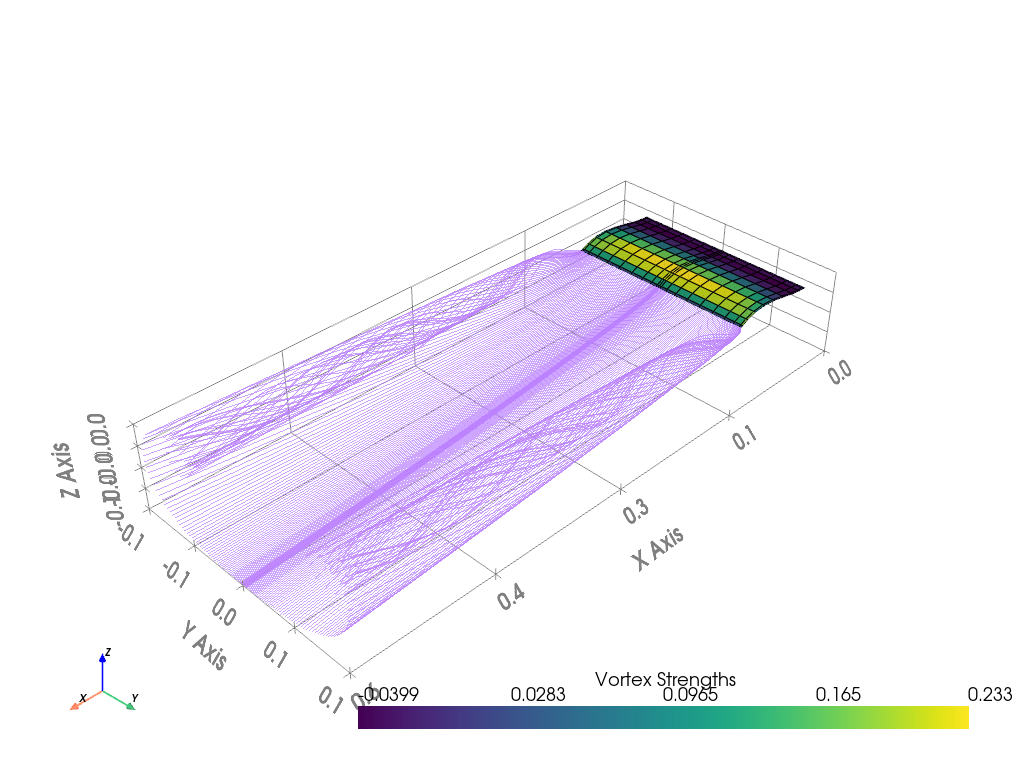

/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/stable_baselines3/ppo/ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 100`, after every 1 untruncated mini-batches, there will be a truncated mini-batch of size 36
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=100 and n_envs=1)
  warnings.warn(


{'F_g': array([3.88634559e-01, 2.91200608e-31, 3.80068938e+00]), 'F_b': (-0.3886345592268883, 2.9120060759135006e-31, -3.800689382311881), 'F_w': (-0.3886345592268883, 2.9120060759135006e-31, -3.800689382311881), 'M_g': array([-3.74591851e-17, -3.00050105e-01, -2.30392962e-18]), 'M_b': (3.745918505937418e-17, -0.3000501049878374, 2.303929616531697e-18), 'M_w': (3.745918505937418e-17, -0.3000501049878374, 2.303929616531697e-18), 'L': 3.800689382311881, 'D': 0.3886345592268883, 'Y': 2.9120060759135006e-31, 'l_b': 3.745918505937418e-17, 'm_b': -0.3000501049878374, 'n_b': 2.303929616531697e-18, 'CL': 0.6284033317333673, 'CD': 0.06425656697479226, 'CY': 4.814690536533016e-32, 'Cl': 3.0967377661640063e-17, 'Cm': -0.496100750929062, 'Cn': 1.9046505797680215e-18}


Output()

We lerned


In [5]:
from stable_baselines3 import PPO
import os
import time

models_dir = f"models/A2C-{int(time.time())}"
logdir = f"logs/A2C-{int(time.time())}"

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(logdir):
    os.makedirs(logdir)

steps = 100 #steps per episode used in model training before resetting
env = AeroEnv(
    episodeSteps=steps,
    numChords=2, 
	initialYSpacing=0.1, 
	initialChordLength=0.1, 
	initialUpperKulfan=1.5, 
	initialLowerKulfan=-0.3, 
	initialLEW=0, 
	initialN1=2, 
	initialN2=1, 
    dX_bounds = (-0.02, 0.02),
	dY_bounds = (0.0, 0.2),
	dZ_bounds = (-0.02, 0.02),
	dChord_bounds = (0, 0.2),
	dTwist_bounds = (-1, 1),
	KT_bounds = (0, 2),
	KB_bounds = (-2, 0),
	N_bounds = (1, 3),
	LEW_bounds = (0, 0.4),
	kulfanWeightResolution = 5
)

env.reset()
env.render()

model = PPO(
	n_steps=steps,
	policy="MlpPolicy",
	env=env,
    learning_rate=.0005,
	verbose=0,
    tensorboard_log=logdir
)

total_timesteps = 10000
model.learn(total_timesteps=total_timesteps, progress_bar=True)

print("We lerned")

/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


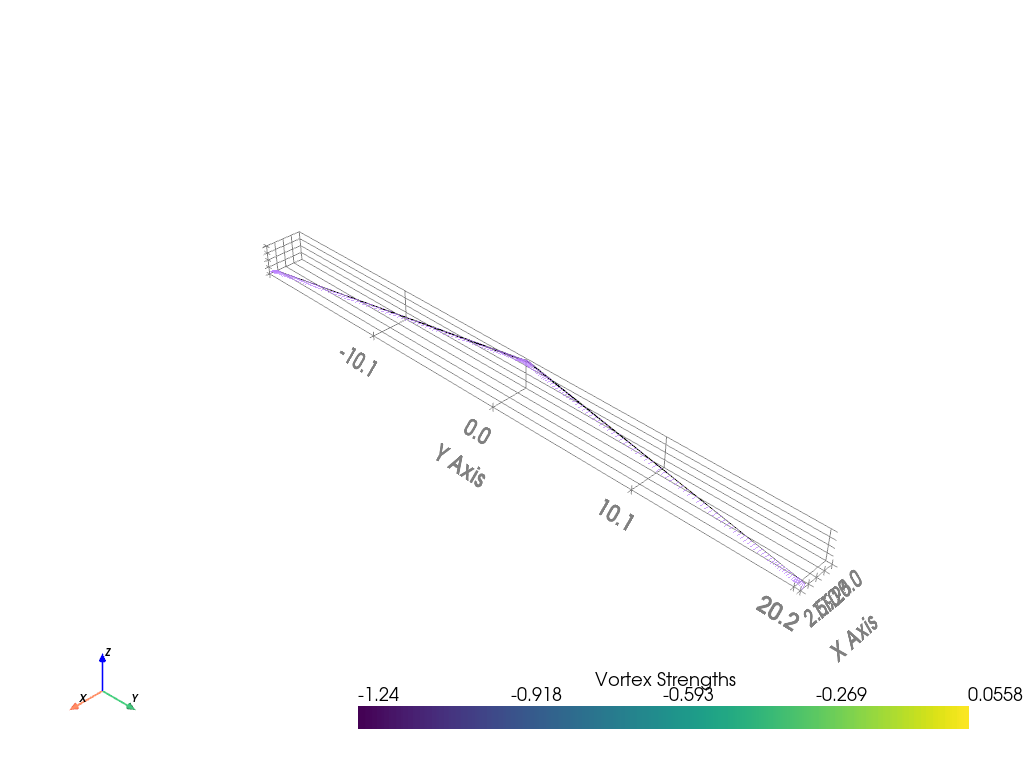

{'F_g': array([ 4.11674748e+01, -2.16701657e-14, -7.06294749e+03]), 'F_b': (-41.16747479932249, -2.1670165661902274e-14, 7062.947493170479), 'F_w': (-41.16747479932249, -2.1670165661902274e-14, 7062.947493170479), 'M_g': array([-7.11075643e-12,  6.65397026e+03, -3.26183525e-13]), 'M_b': (7.110756428119203e-12, 6653.970256220406, 3.26183524634871e-13), 'M_w': (7.110756428119203e-12, 6653.970256220406, 3.26183524634871e-13), 'L': -7062.947493170479, 'D': 41.16747479932249, 'Y': -2.1670165661902274e-14, 'l_b': 7.110756428119203e-12, 'm_b': 6653.970256220406, 'n_b': 3.26183524634871e-13, 'CL': -5.787091354269255, 'CD': 0.033730951237938955, 'CY': -1.775565066409452e-17, 'Cl': 1.4434826206815147e-16, 'Cm': 54.51992072512557, 'Cn': 6.621521264617615e-18}


/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


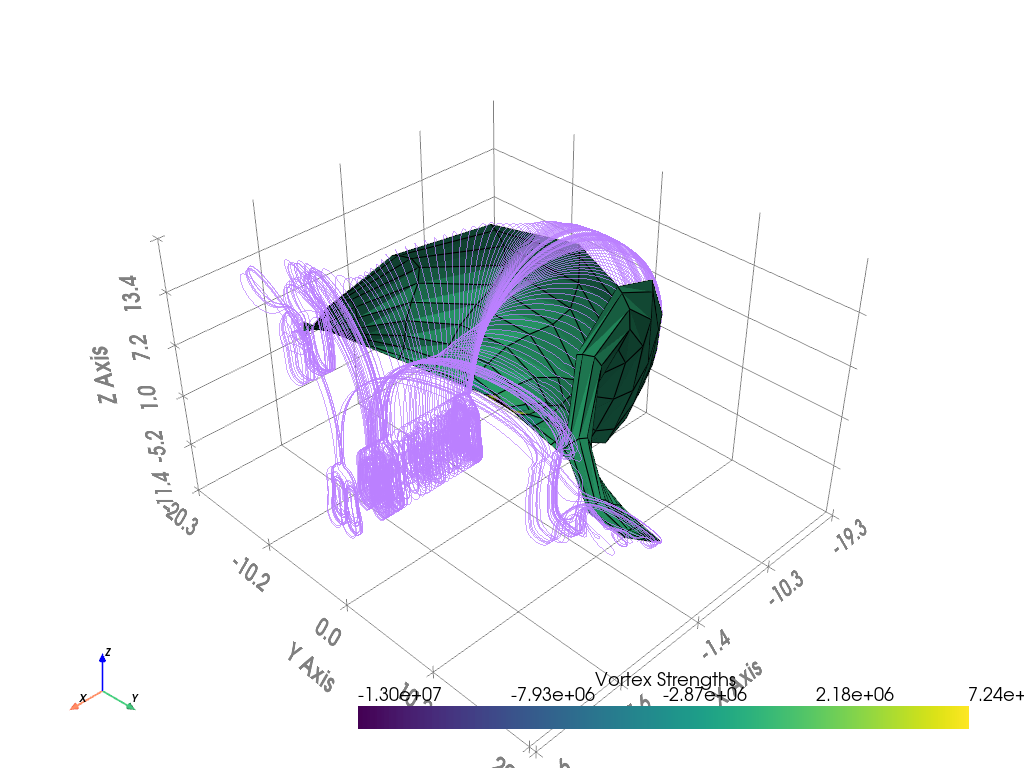

{'F_g': array([3.51285356e+14, 8.53536688e+02, 2.94034159e+12]), 'F_b': (-351285356270574.44, 853.5366878264729, -2940341593646.8228), 'F_w': (-351285356270574.44, 853.5366878264729, -2940341593646.8228), 'M_g': array([ 2.29143085e+02, -1.18638854e+14,  4.28238689e+03]), 'M_b': (-229.14308530460818, -118638853803152.89, -4282.386885475926), 'M_w': (-229.14308530460818, -118638853803152.89, -4282.386885475926), 'L': 2940341593646.8228, 'D': 351285356270574.44, 'Y': 853.5366878264729, 'l_b': -229.14308530460818, 'm_b': -118638853803152.89, 'n_b': -4282.386885475926, 'CL': 23881977.966760386, 'CD': 2853202211.8199906, 'CY': 0.006932576955186892, 'Cl': -4.6134623128671325e-05, 'Cm': -71909115.53641857, 'Cn': -0.000862196233370797}


/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


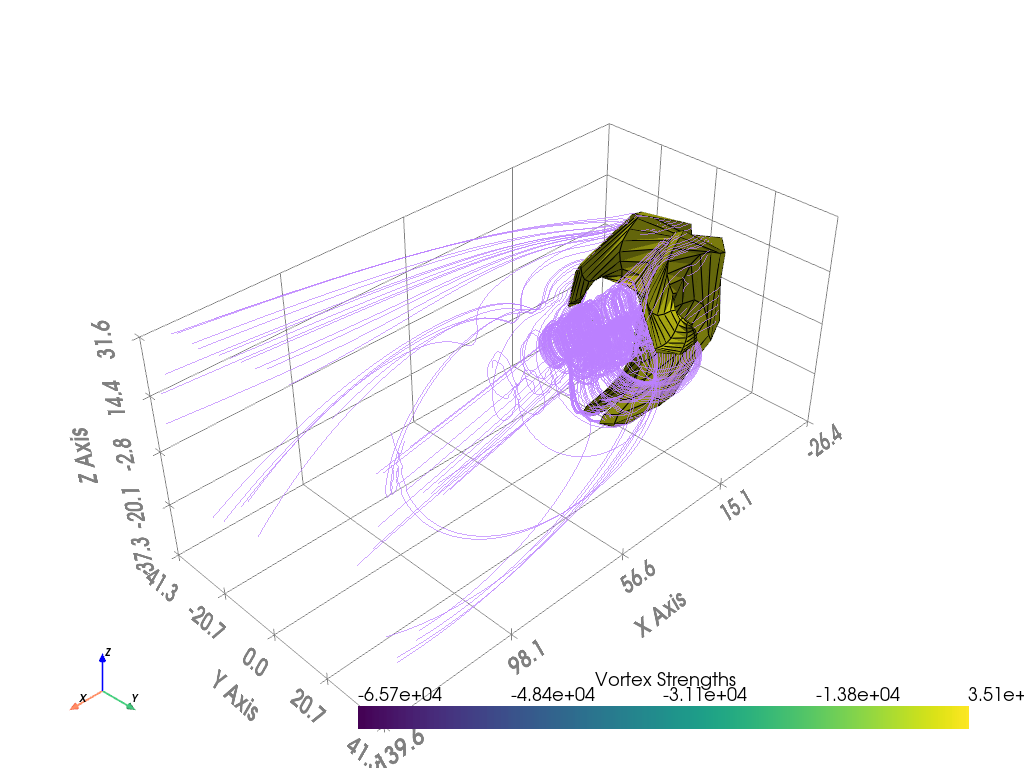

{'F_g': array([ 3.03063256e+09, -2.21437369e-03, -1.63846707e+09]), 'F_b': (-3030632564.7520647, -0.002214373687479565, 1638467072.195441), 'F_w': (-3030632564.7520647, -0.002214373687479565, 1638467072.195441), 'M_g': array([-6.25223597e-03, -4.94623493e+09, -5.26088879e-03]), 'M_b': (0.006252235969441244, -4946234925.391705, 0.005260888785869611), 'M_w': (0.006252235969441244, -4946234925.391705, 0.005260888785869611), 'L': -1638467072.195441, 'D': 3030632564.7520647, 'Y': -0.002214373687479565, 'l_b': 0.006252235969441244, 'm_b': -4946234925.391705, 'n_b': 0.005260888785869611, 'CL': -5394.441251583561, 'CD': 9977.966358387044, 'CY': -7.290539412644418e-09, 'Cl': 4.5743831771182614e-10, 'Cm': -595.4360952979489, 'Cn': 3.849074359380386e-10}


/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


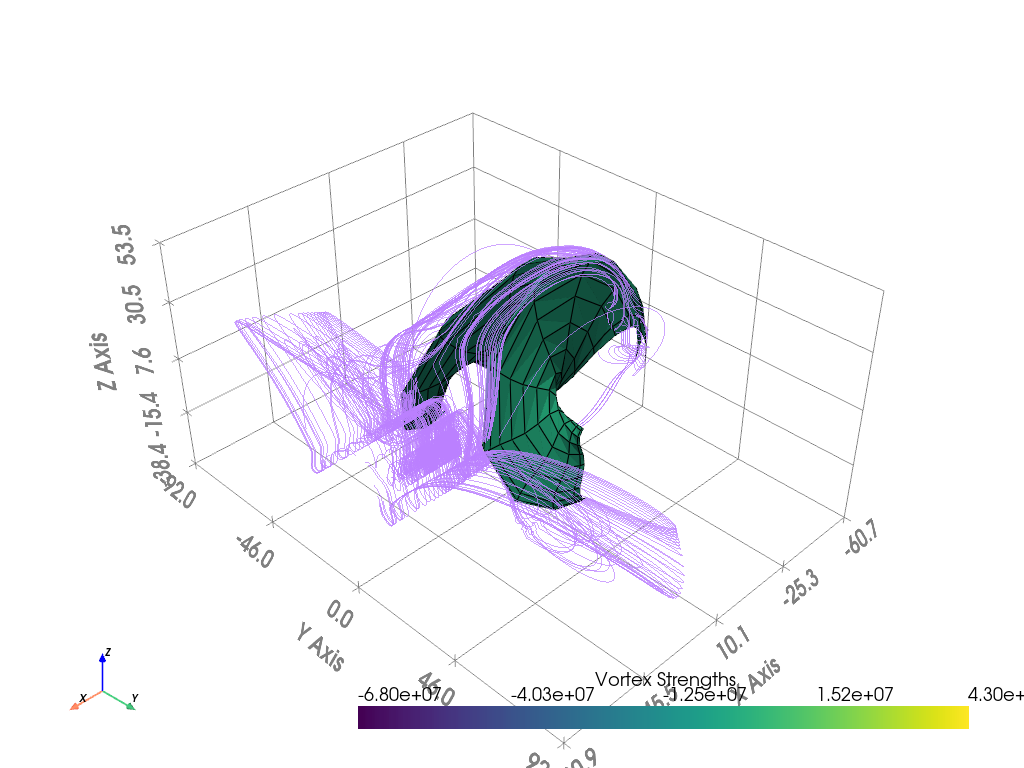

{'F_g': array([ 7.60614195e+15,  6.31280449e+06, -8.73577318e+13]), 'F_b': (-7606141950802741.0, 6312804.493382983, 87357731755660.06), 'F_w': (-7606141950802741.0, 6312804.493382983, 87357731755660.06), 'M_g': array([ 2.31228156e+06, -2.93834610e+15,  3.05457205e+07]), 'M_b': (-2312281.562009752, -2938346096605115.5, -30545720.502351854), 'M_w': (-2312281.562009752, -2938346096605115.5, -30545720.502351854), 'L': -87357731755660.06, 'D': 7606141950802741.0, 'Y': 6312804.493382983, 'l_b': -2312281.562009752, 'm_b': -2938346096605115.5, 'n_b': -30545720.502351854, 'CL': -105820591.59376831, 'CD': 9213682919.691593, 'CY': 7.6470015038171315, 'Cl': -0.04364267183125586, 'Cm': -78234597.88217254, 'Cn': -0.5765287747114698}


/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


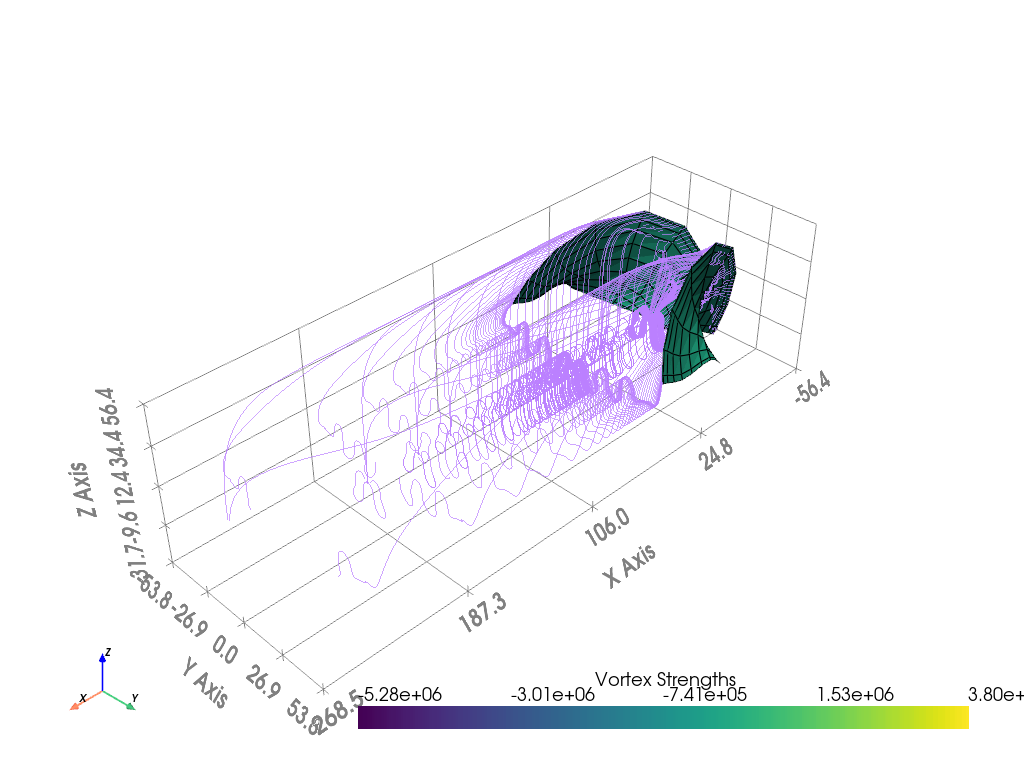

{'F_g': array([ 9.82098911e+13,  5.91022811e+02, -1.63032548e+11]), 'F_b': (-98209891133921.92, 591.0228106852354, 163032547922.8688), 'F_w': (-98209891133921.92, 591.0228106852354, 163032547922.8688), 'M_g': array([ 4.84667456e+02, -1.29860410e+14,  1.38592041e+04]), 'M_b': (-484.66745619910716, -129860410266098.52, -13859.204138111909), 'M_w': (-484.66745619910716, -129860410266098.52, -13859.204138111909), 'L': -163032547922.8688, 'D': 98209891133921.92, 'Y': 591.0228106852354, 'l_b': -484.66745619910716, 'm_b': -129860410266098.52, 'n_b': -13859.204138111909, 'CL': -96771.19979335633, 'CD': 58294427.20297084, 'CY': 0.0003508133021530803, 'Cl': -2.73614496235085e-06, 'Cm': -1437553.4123526607, 'Cn': -7.824084555227212e-05}


/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


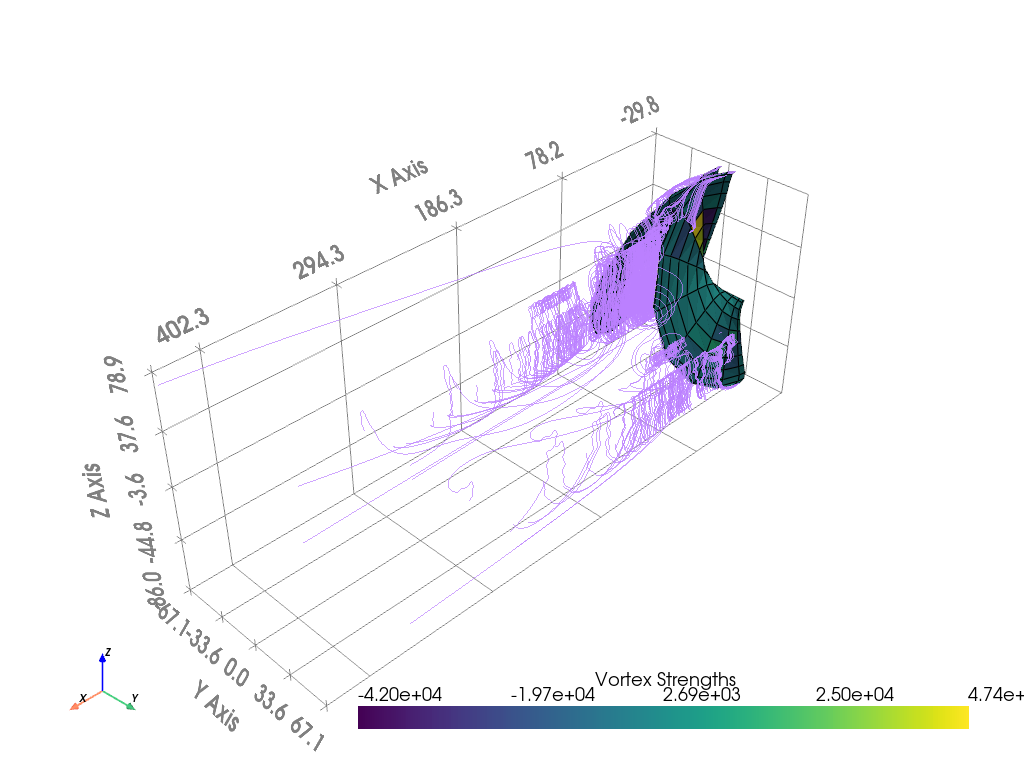

{'F_g': array([ 8.65749741e+09,  3.87701765e-04, -2.16913537e+09]), 'F_b': (-8657497405.535162, 0.0003877017650779635, 2169135371.880765), 'F_w': (-8657497405.535162, 0.0003877017650779635, 2169135371.880765), 'M_g': array([-1.51024505e-02,  1.88774168e+11,  4.28646064e-04]), 'M_b': (0.015102450488484465, 188774167937.00937, -0.00042864606439252384), 'M_w': (0.015102450488484465, 188774167937.00937, -0.00042864606439252384), 'L': -2169135371.880765, 'D': 8657497405.535162, 'Y': 0.0003877017650779635, 'l_b': 0.015102450488484465, 'm_b': 188774167937.00937, 'n_b': -0.00042864606439252384, 'CL': -785.8611395988263, 'CD': 3136.5450332814594, 'CY': 1.404613814694608e-10, 'Cl': 4.2907634106795455e-11, 'Cm': 929.9683005167814, 'Cn': -1.217828093943843e-12}


/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


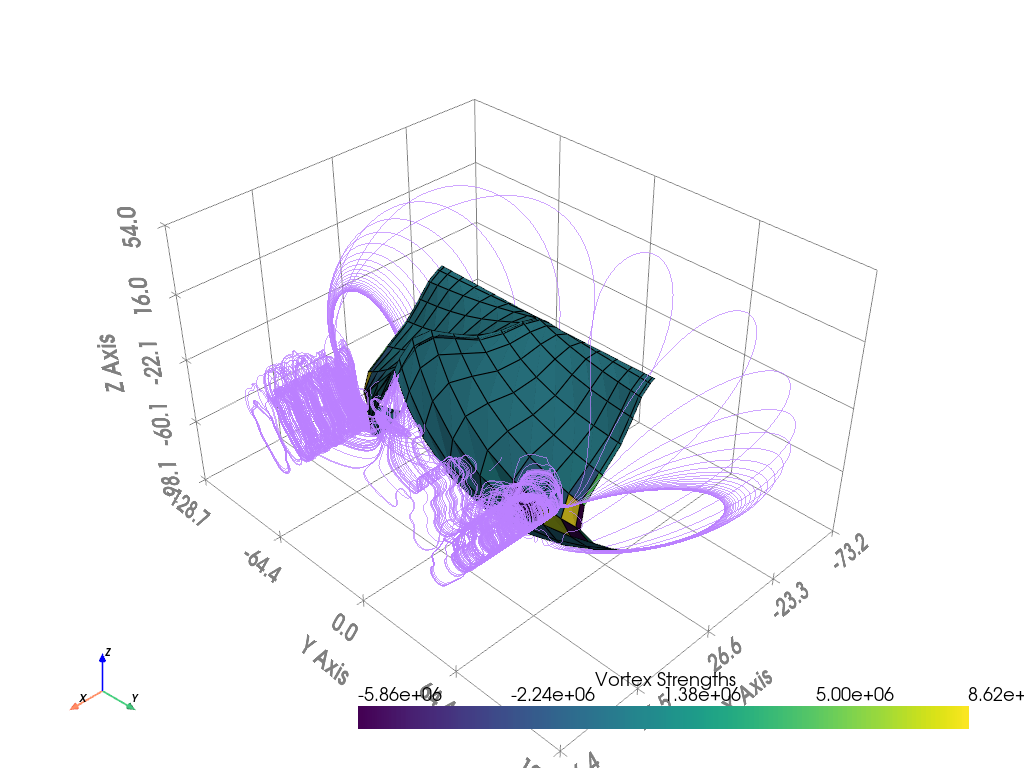

{'F_g': array([ 2.89026788e+14, -6.19678431e+00, -8.52555113e+13]), 'F_b': (-289026787946805.25, -6.196784313302487, 85255511302219.27), 'F_w': (-289026787946805.25, -6.196784313302487, 85255511302219.27), 'M_g': array([ 7.33337938e+01, -6.21592922e+15,  7.16020677e+02]), 'M_b': (-73.33379384875298, -6215929217653448.0, -716.0206769555807), 'M_w': (-73.33379384875298, -6215929217653448.0, -716.0206769555807), 'L': -85255511302219.27, 'D': 289026787946805.25, 'Y': -6.196784313302487, 'l_b': -73.33379384875298, 'm_b': -6215929217653448.0, 'n_b': -716.0206769555807, 'CL': -19897643.95735209, 'CD': 67455488.01315947, 'CY': -1.4462573276877153e-06, 'Cl': -1.1208440793889447e-07, 'Cm': -15516263.880596677, 'Cn': -1.0943761318839415e-06}


/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


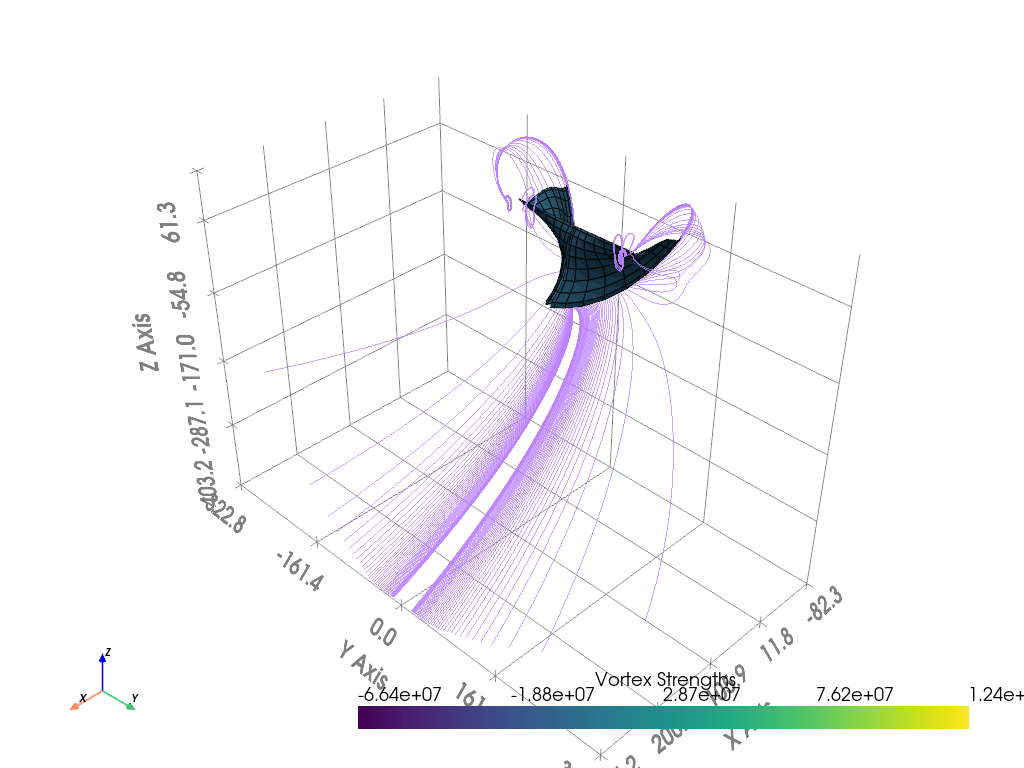

{'F_g': array([ 4.05537295e+16,  9.02047492e+02, -5.26004698e+10]), 'F_b': (-4.055372948519438e+16, 902.0474918666039, 52600469817.49726), 'F_w': (-4.055372948519438e+16, 902.0474918666039, 52600469817.49726), 'M_g': array([-2.57110284e+03,  5.37304071e+16,  4.80554597e+06]), 'M_b': (2571.102842051844, 5.373040712279465e+16, -4805545.974540321), 'M_w': (2571.102842051844, 5.373040712279465e+16, -4805545.974540321), 'L': -52600469817.49726, 'D': 4.055372948519438e+16, 'Y': 902.0474918666039, 'l_b': 2571.102842051844, 'm_b': 5.373040712279465e+16, 'n_b': -4805545.974540321, 'CL': -9946.850301930168, 'CD': 7668788468.5018015, 'CY': 0.00017057892064386115, 'Cl': 2.5644119870447732e-06, 'Cm': 108672083.7065014, 'Cn': -0.004793040363788554}


/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


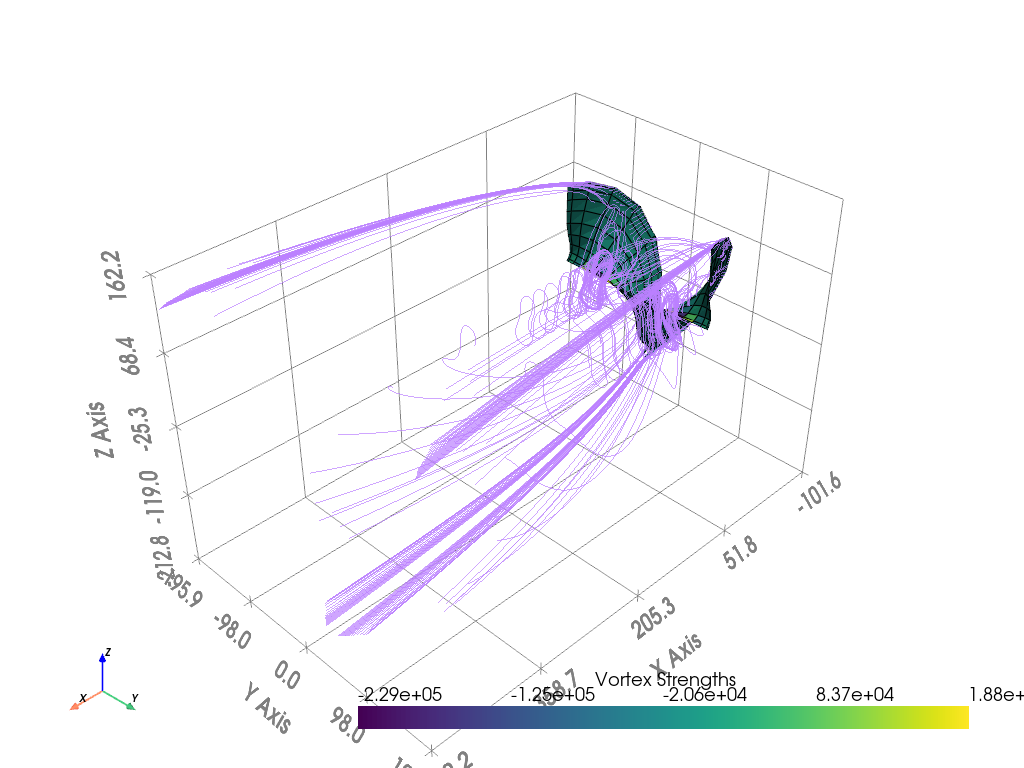

{'F_g': array([ 5.25122101e+11, -5.94854049e-03,  1.46661869e+08]), 'F_b': (-525122101246.0942, -0.005948540493875498, -146661868.57813603), 'F_w': (-525122101246.0942, -0.005948540493875498, -146661868.57813603), 'M_g': array([-2.17128125e-01,  6.79760097e+10, -2.93178778e+01]), 'M_b': (0.21712812548139482, 67976009694.876976, 29.317877755265727), 'M_w': (0.21712812548139482, 67976009694.876976, 29.317877755265727), 'L': 146661868.57813603, 'D': 525122101246.0942, 'Y': -0.005948540493875498, 'l_b': 0.21712812548139482, 'm_b': 67976009694.876976, 'n_b': 29.317877755265727, 'CL': 19.440778995021887, 'CD': 69607.61385832174, 'CY': -7.885093937880718e-10, 'Cl': 1.1872998631525437e-10, 'Cm': 87.17037789008484, 'Cn': 1.6031599853577106e-08}


/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


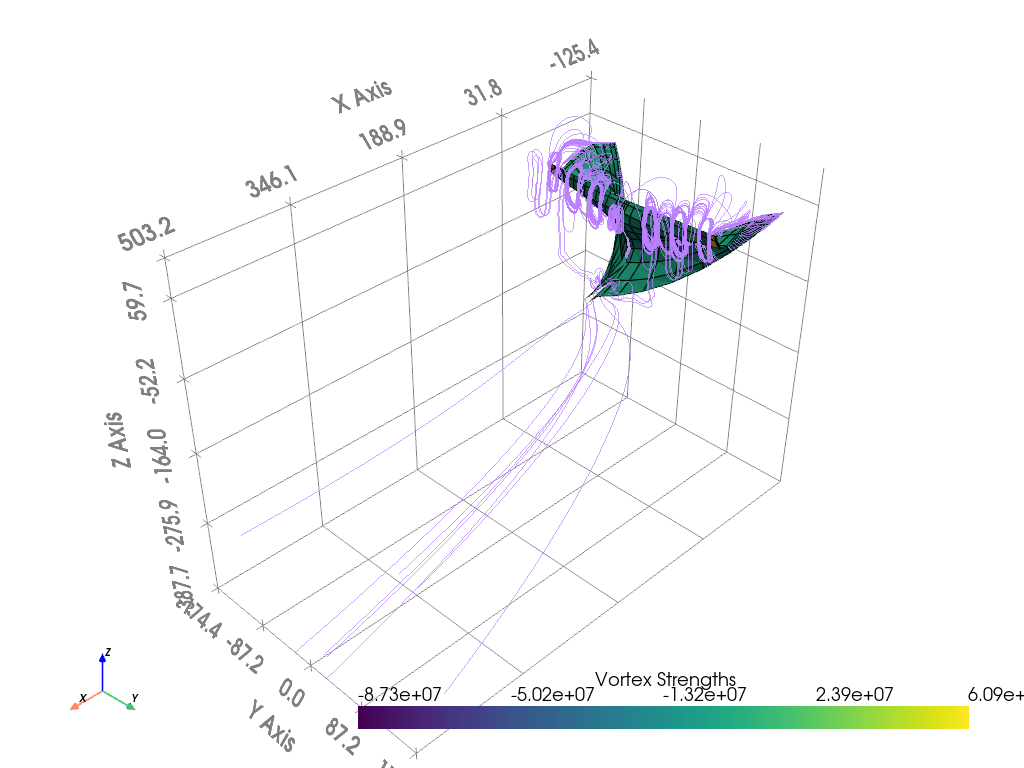

{'F_g': array([2.52489582e+16, 1.68010063e+06, 6.52472427e+13]), 'F_b': (-2.524895821492078e+16, 1680100.627019245, -65247242733904.77), 'F_w': (-2.524895821492078e+16, 1680100.627019245, -65247242733904.77), 'M_g': array([ 1.63727221e+07, -7.00519390e+16, -2.91419105e+09]), 'M_b': (-16372722.05940631, -7.00519390447045e+16, 2914191050.0621824), 'M_w': (-16372722.05940631, -7.00519390447045e+16, 2914191050.0621824), 'L': 65247242733904.77, 'D': 2.524895821492078e+16, 'Y': 1680100.627019245, 'l_b': -16372722.05940631, 'm_b': -7.00519390447045e+16, 'n_b': 2914191050.0621824, 'CL': 7265562.982133642, 'CD': 2811580818.700888, 'CY': 0.18708647922048394, 'Cl': -0.00691523585121444, 'Cm': -68517162.11818875, 'Cn': 1.2308471586800394}


/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


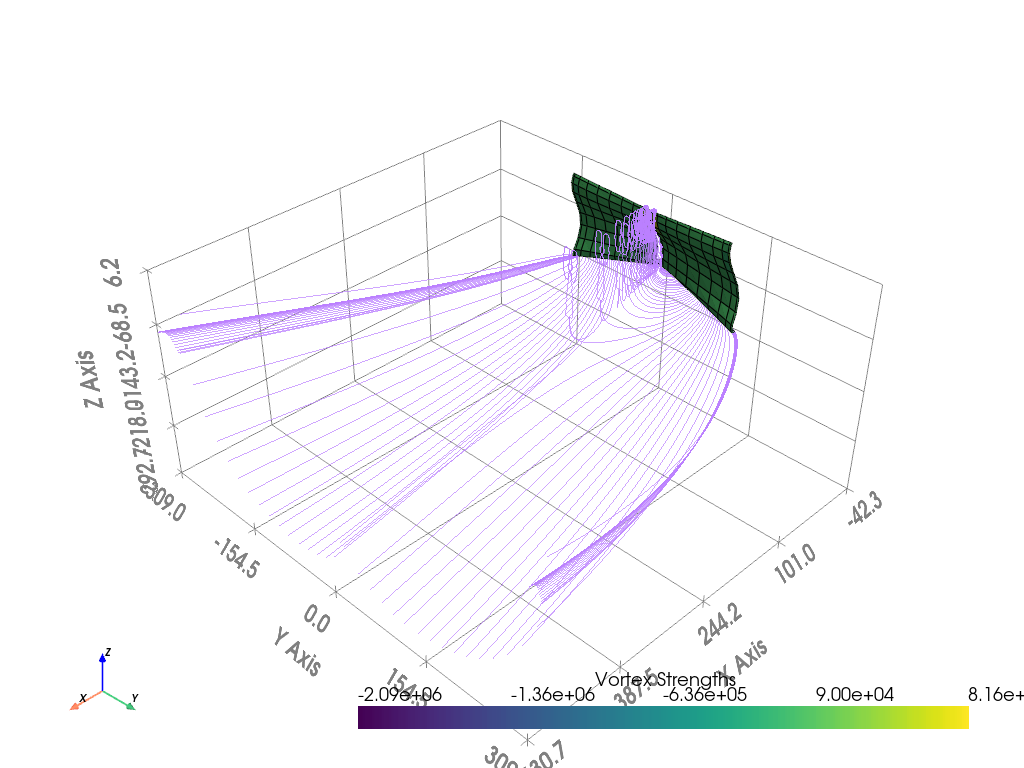

{'F_g': array([ 7.79437195e+12, -1.16545304e+01,  7.98823430e+09]), 'F_b': (-7794371953699.655, -11.6545303636276, -7988234300.900841), 'F_w': (-7794371953699.655, -11.6545303636276, -7988234300.900841), 'M_g': array([-1.69821598e+02, -1.11035037e+14, -6.86578125e+02]), 'M_b': (169.82159757887712, -111035036695174.02, 686.5781249240972), 'M_w': (169.82159757887712, -111035036695174.02, 686.5781249240972), 'L': 7988234300.900841, 'D': 7794371953699.655, 'Y': -11.6545303636276, 'l_b': 169.82159757887712, 'm_b': -111035036695174.02, 'n_b': 686.5781249240972, 'CL': 871.5032367525334, 'CD': 850353.1732083003, 'CY': -1.2714901131013052e-06, 'Cl': 7.073223737263769e-08, 'Cm': -103119.87614563973, 'Cn': 2.859660231640182e-07}


/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


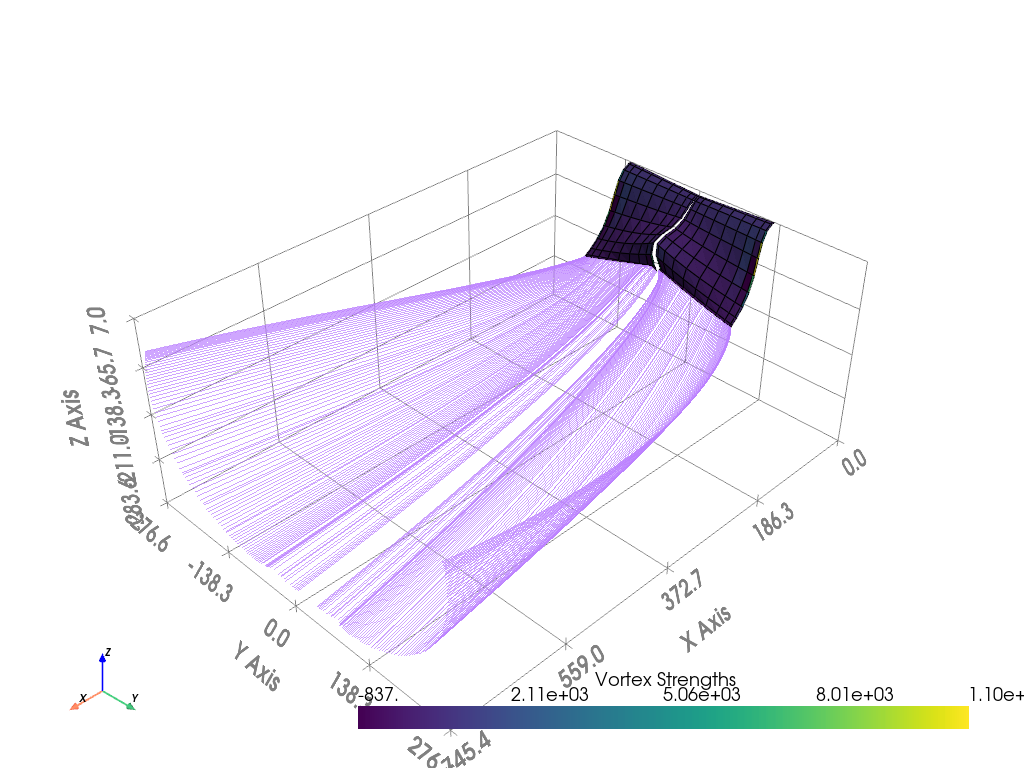

{'F_g': array([2.99717311e+08, 8.58608473e-09, 4.33885542e+07]), 'F_b': (-299717311.257808, 8.586084732087329e-09, -43388554.22301397), 'F_w': (-299717311.257808, 8.586084732087329e-09, -43388554.22301397), 'M_g': array([ 1.01455953e-06, -1.32613827e+10,  2.85080750e-05]), 'M_b': (-1.014559529721737e-06, -13261382717.371582, -2.8508075047284365e-05), 'M_w': (-1.014559529721737e-06, -13261382717.371582, -2.8508075047284365e-05), 'L': 43388554.22301397, 'D': 299717311.257808, 'Y': 8.586084732087329e-09, 'l_b': -1.014559529721737e-06, 'm_b': -13261382717.371582, 'n_b': -2.8508075047284365e-05, 'CL': 4.036073529856005, 'CD': 27.880189328032934, 'CY': 7.986914967057695e-16, 'Cl': -3.599143720118184e-16, 'Cm': -8.980915151008054, 'Cn': -1.0113222169154803e-14}


/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


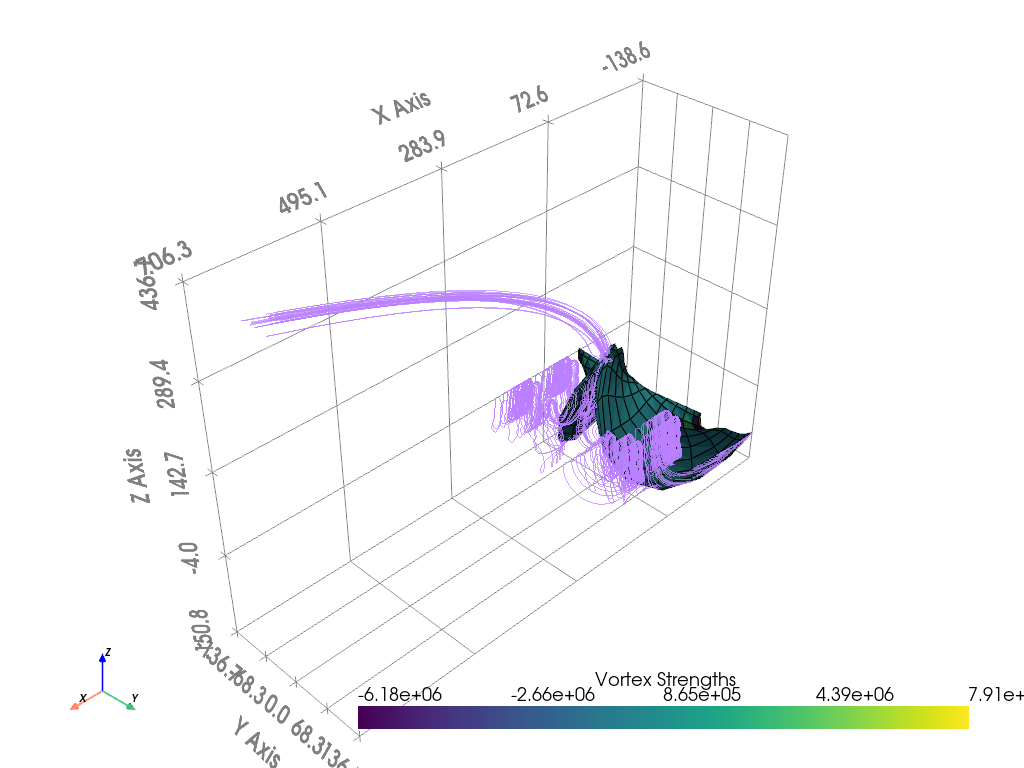

{'F_g': array([ 2.10085910e+14, -1.08733261e+02, -5.58228834e+12]), 'F_b': (-210085909591062.62, -108.73326139408368, 5582288337444.167), 'F_w': (-210085909591062.62, -108.73326139408368, 5582288337444.167), 'M_g': array([-9.79528113e+02, -2.62647476e+15,  2.76339880e+04]), 'M_b': (979.5281133125536, -2626474760611837.5, -27633.988000224475), 'M_w': (979.5281133125536, -2626474760611837.5, -27633.988000224475), 'L': -5582288337444.167, 'D': 210085909591062.62, 'Y': -108.73326139408368, 'l_b': 979.5281133125536, 'm_b': -2626474760611837.5, 'n_b': -27633.988000224475, 'CL': -453985.1895815946, 'CD': 17085446.99390929, 'CY': -8.84284137684278e-06, 'Cl': 2.8420201520594507e-07, 'Cm': -1440398.7519738344, 'Cn': -8.017774039462117e-06}


/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


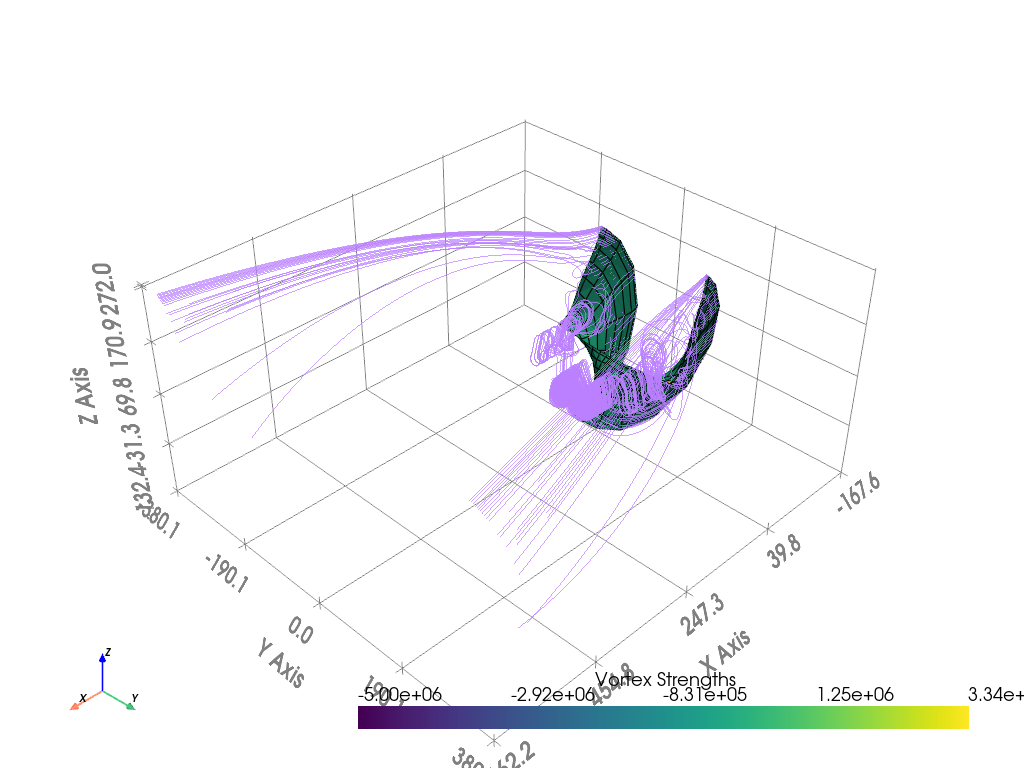

{'F_g': array([ 4.96509665e+13, -2.79950609e+01,  5.32990909e+10]), 'F_b': (-49650966505709.7, -27.99506093887817, -53299090895.96303), 'F_w': (-49650966505709.7, -27.99506093887817, -53299090895.96303), 'M_g': array([-2.57695458e+02,  5.13716386e+14,  4.77666366e+05]), 'M_b': (257.6954576604476, 513716386225694.1, -477666.36563129025), 'M_w': (257.6954576604476, 513716386225694.1, -477666.36563129025), 'L': 53299090895.96303, 'D': 49650966505709.7, 'Y': -27.99506093887817, 'l_b': 257.6954576604476, 'm_b': 513716386225694.1, 'n_b': -477666.36563129025, 'CL': 3816.479985600549, 'CD': 3555256.1356936153, 'CY': -2.0045855937289294e-06, 'Cl': 6.178259681368151e-08, 'Cm': 230575.35359910244, 'Cn': -0.00011452071661325271}


/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


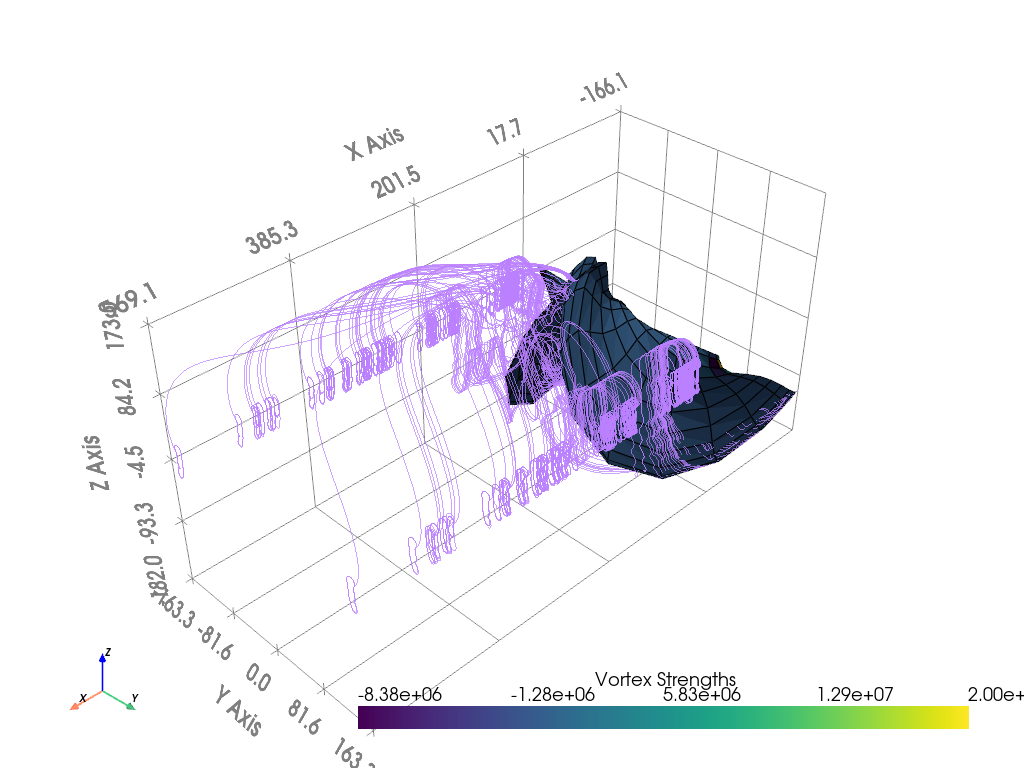

{'F_g': array([ 6.43144494e+14, -3.35020394e+02,  2.60031318e+13]), 'F_b': (-643144493780977.0, -335.02039389988295, -26003131821328.49), 'F_w': (-643144493780977.0, -335.02039389988295, -26003131821328.49), 'M_g': array([-9.04723536e+03,  6.51744159e+14,  1.93248075e+05]), 'M_b': (9047.235363206244, 651744159022026.8, -193248.07511144225), 'M_w': (9047.235363206244, 651744159022026.8, -193248.07511144225), 'L': 26003131821328.49, 'D': 643144493780977.0, 'Y': -335.02039389988295, 'l_b': 9047.235363206244, 'm_b': 651744159022026.8, 'n_b': -193248.07511144225, 'CL': 1500071.0026343414, 'CD': 37101777.28797503, 'CY': -1.9326686555814805e-05, 'Cl': 1.5822856707165289e-06, 'Cm': 210328.9910551544, 'Cn': -3.379746937787453e-05}


/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


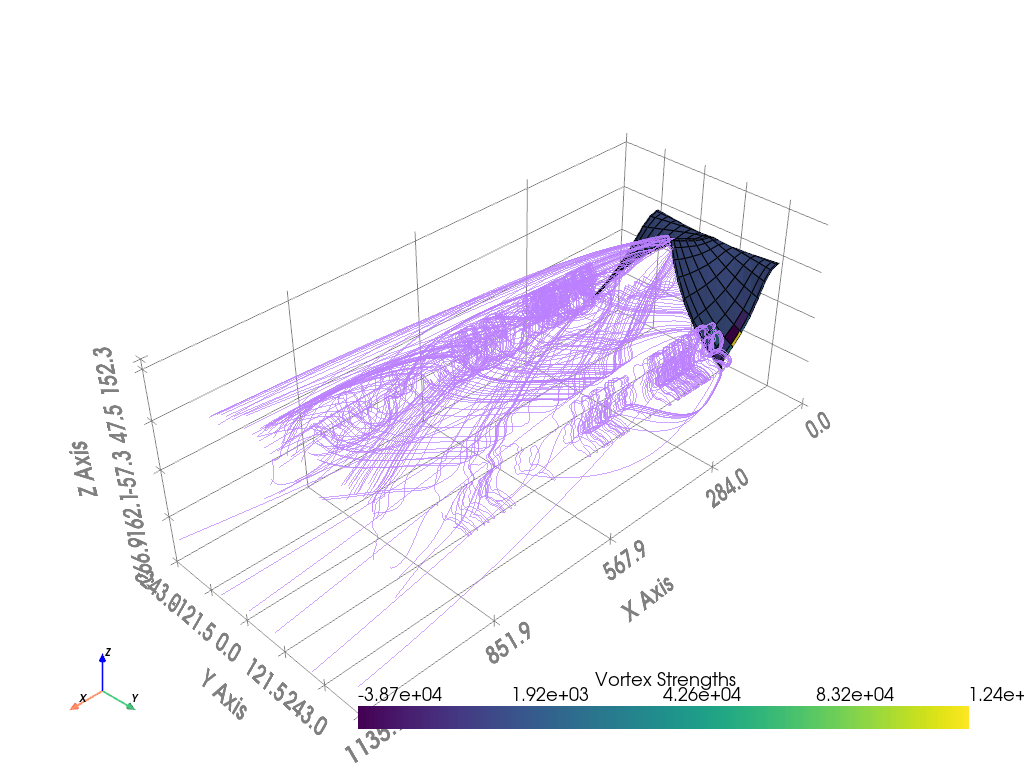

{'F_g': array([ 1.65643559e+10, -7.61961564e-06, -3.74211909e+09]), 'F_b': (-16564355859.958414, -7.6196156442165375e-06, 3742119087.8793793), 'F_w': (-16564355859.958414, -7.6196156442165375e-06, 3742119087.8793793), 'M_g': array([ 2.76505947e-04, -9.73180024e+11,  3.45039368e-03]), 'M_b': (-0.0002765059471130371, -973180023985.2122, -0.0034503936767578125), 'M_w': (-0.0002765059471130371, -973180023985.2122, -0.0034503936767578125), 'L': -3742119087.8793793, 'D': 16564355859.958414, 'Y': -7.6196156442165375e-06, 'l_b': -0.0002765059471130371, 'm_b': -973180023985.2122, 'n_b': -0.0034503936767578125, 'CL': -194.7002426897407, 'CD': 861.8336376250264, 'CY': -3.9644409498795835e-13, 'Cl': -4.3939291456079915e-14, 'Cm': -255.093892594341, 'Cn': -5.482987074390072e-13}


/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


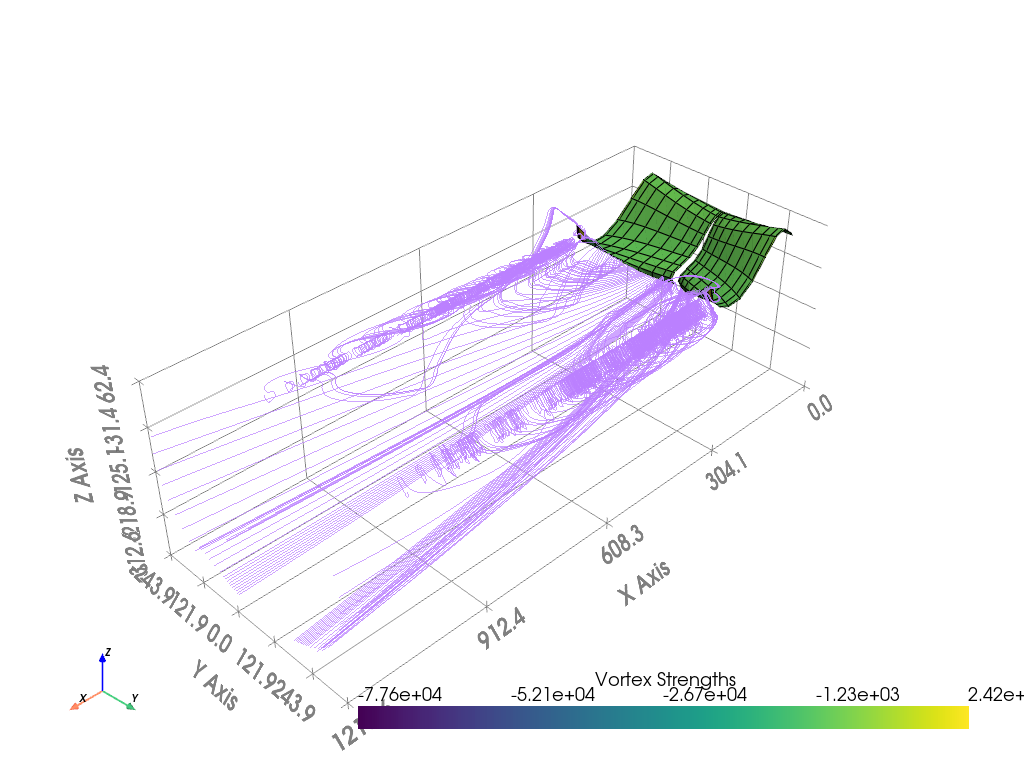

{'F_g': array([ 6.40778315e+09, -2.74181366e-06, -1.78585873e+09]), 'F_b': (-6407783154.585213, -2.7418136596679688e-06, 1785858729.0075667), 'F_w': (-6407783154.585213, -2.7418136596679688e-06, 1785858729.0075667), 'M_g': array([-1.52587891e-04,  2.89778586e+11, -1.83105469e-03]), 'M_b': (0.000152587890625, 289778585659.5074, 0.0018310546875), 'M_w': (0.000152587890625, 289778585659.5074, 0.0018310546875), 'L': -1785858729.0075667, 'D': 6407783154.585213, 'Y': -2.7418136596679688e-06, 'l_b': 0.000152587890625, 'm_b': 289778585659.5074, 'n_b': 0.0018310546875, 'CL': -78.5923695300364, 'CD': 281.9947924063201, 'CY': -1.2066219394793653e-13, 'Cl': 1.907104104056535e-14, 'Cm': 58.42461853587859, 'Cn': 2.2885249248678424e-13}


/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


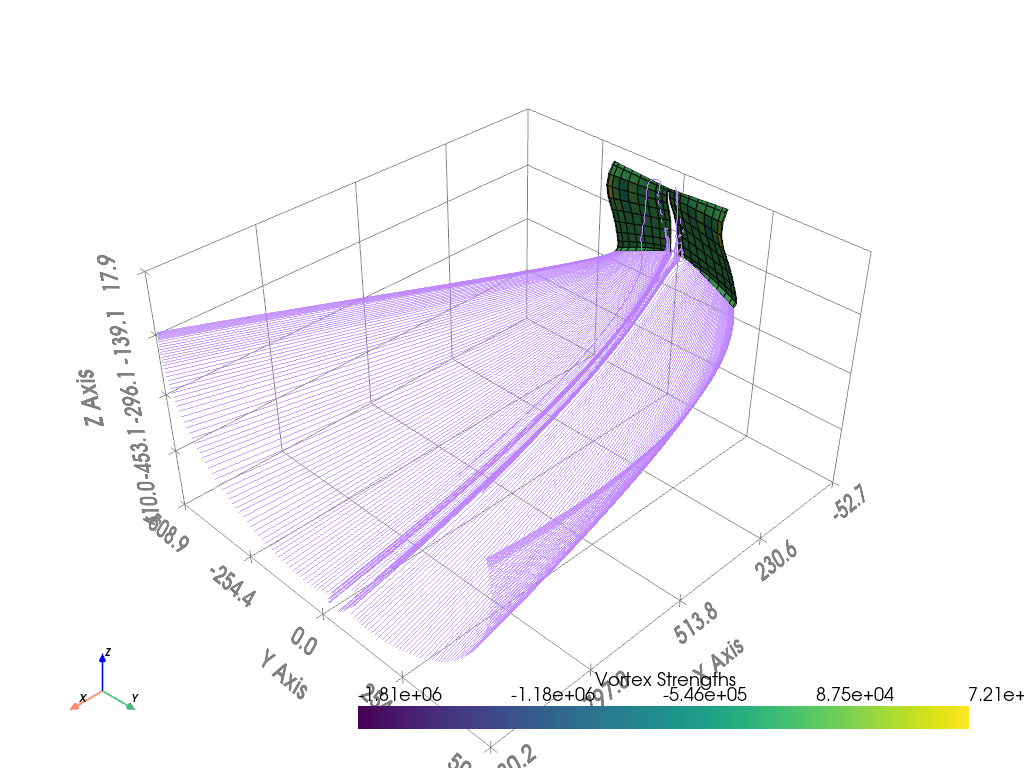

{'F_g': array([5.13887928e+12, 2.77878727e-03, 3.50453982e+10]), 'F_b': (-5138879276522.351, 0.0027787872679709835, -35045398210.37097), 'F_w': (-5138879276522.351, 0.0027787872679709835, -35045398210.37097), 'M_g': array([ 1.11289546e-01, -2.84616382e+14,  1.36043858e+00]), 'M_b': (-0.11128954554442316, -284616381555678.4, -1.3604385835351422), 'M_w': (-0.11128954554442316, -284616381555678.4, -1.3604385835351422), 'L': 35045398210.37097, 'D': 5138879276522.351, 'Y': 0.0027787872679709835, 'l_b': -0.11128954554442316, 'm_b': -284616381555678.4, 'n_b': -1.3604385835351422, 'CL': 1421.1451690291242, 'CD': 208389.51277467344, 'CY': 1.126841269695705e-10, 'Cl': -1.2840599794054092e-11, 'Cm': -48474.94681536996, 'Cn': -1.5696755081627671e-10}


/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


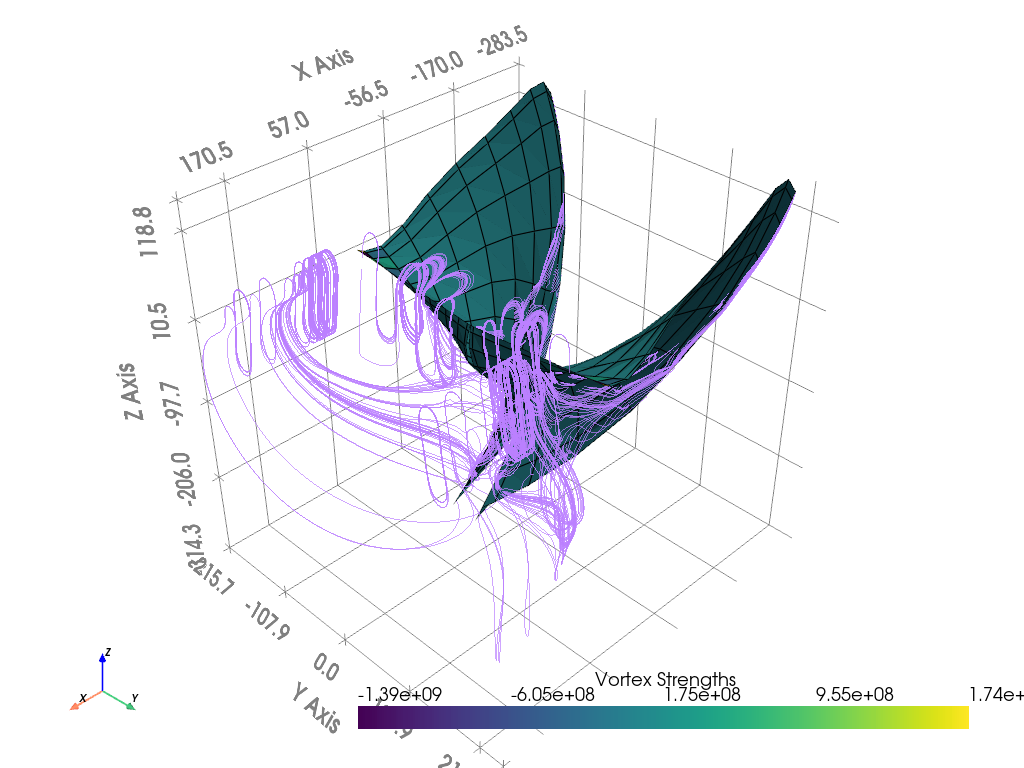

{'F_g': array([7.98370495e+18, 9.65579998e+08, 3.17699164e+16]), 'F_b': (-7.983704950736212e+18, 965579998.2142056, -3.1769916420187524e+16), 'F_w': (-7.983704950736212e+18, 965579998.2142056, -3.1769916420187524e+16), 'M_g': array([ 1.20616391e+10,  7.95438683e+19, -3.04377406e+12]), 'M_b': (-12061639097.065891, 7.954386829927011e+19, 3043774062329.0713), 'M_w': (-12061639097.065891, 7.954386829927011e+19, 3043774062329.0713), 'L': 3.1769916420187524e+16, 'D': 7.983704950736212e+18, 'Y': 965579998.2142056, 'l_b': -12061639097.065891, 'm_b': 7.954386829927011e+19, 'n_b': 3043774062329.0713, 'CL': 1158631657.3768747, 'CD': 291161398624.3171, 'CY': 35.21417994508785, 'Cl': -1.172611408734774, 'Cm': 11642962212.172834, 'Cn': 295.9103785460047}


/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


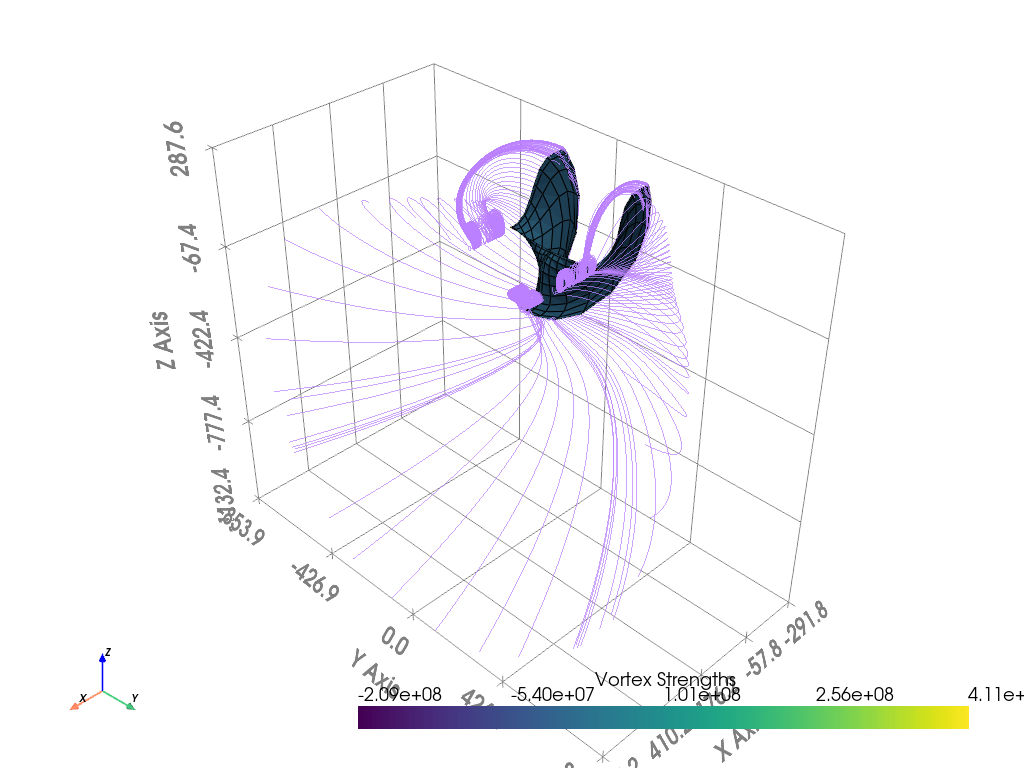

{'F_g': array([2.32972904e+17, 2.40004086e+06, 5.60074902e+14]), 'F_b': (-2.3297290357407094e+17, 2400040.8607746456, -560074901604394.94), 'F_w': (-2.3297290357407094e+17, 2400040.8607746456, -560074901604394.94), 'M_g': array([ 3.64054826e+07,  2.28966976e+18, -1.03523700e+10]), 'M_b': (-36405482.5529854, 2.2896697635803192e+18, 10352369986.516933), 'M_w': (-36405482.5529854, 2.2896697635803192e+18, 10352369986.516933), 'L': 560074901604394.94, 'D': 2.3297290357407094e+17, 'Y': 2400040.8607746456, 'l_b': -36405482.5529854, 'm_b': 2.2896697635803192e+18, 'n_b': 10352369986.516933, 'CL': 17218957.782294754, 'CD': 7162525190.057677, 'CY': 0.07378692053344584, 'Cl': -0.002641006077256166, 'Cm': 270333272.451738, 'Cn': 0.7510042480168554}


/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


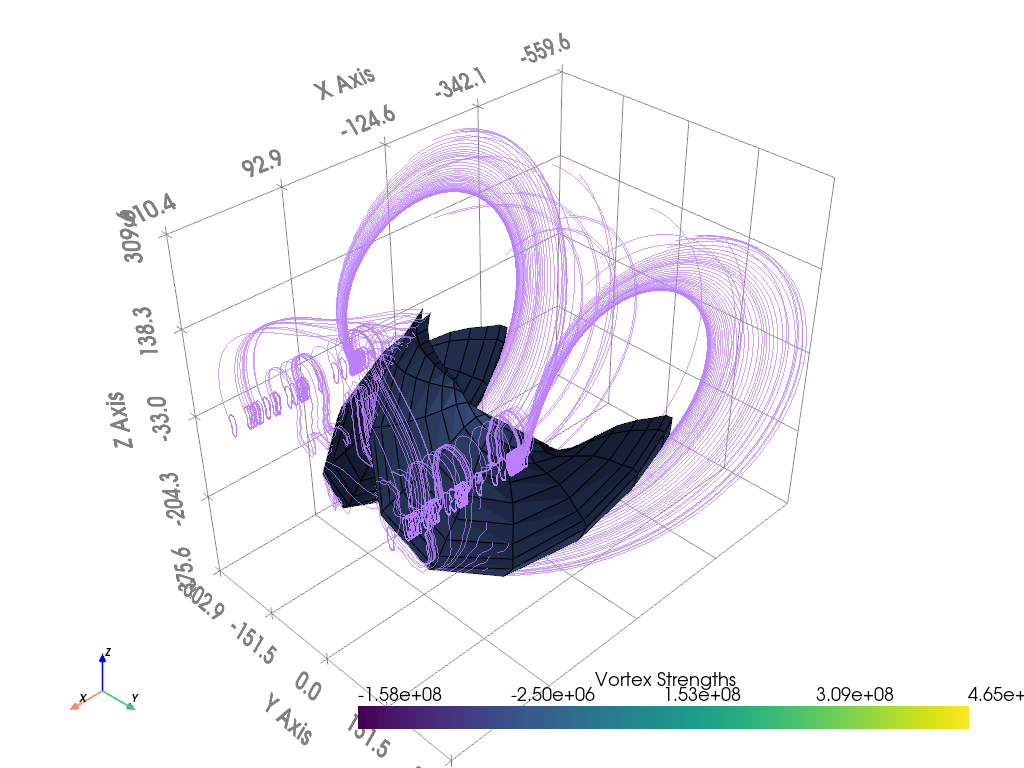

{'F_g': array([ 3.64799151e+17, -5.14266282e+04,  7.94212542e+15]), 'F_b': (-3.6479915087743616e+17, -51426.62823354328, -7942125417358616.0), 'F_w': (-3.6479915087743616e+17, -51426.62823354328, -7942125417358616.0), 'M_g': array([-1.61775251e+06,  1.35735125e+18,  7.66674480e+07]), 'M_b': (1617752.5135705434, 1.3573512516999473e+18, -76667448.04796106), 'M_w': (1617752.5135705434, 1.3573512516999473e+18, -76667448.04796106), 'L': 7942125417358616.0, 'D': 3.6479915087743616e+17, 'Y': -51426.62823354328, 'l_b': 1617752.5135705434, 'm_b': 1.3573512516999473e+18, 'n_b': -76667448.04796106, 'CL': 233320015.76404652, 'CD': 10716897450.070944, 'CY': -0.0015107872363633167, 'Cl': 0.00011137314995695787, 'Cm': 146713522.9829196, 'Cn': -0.005278122034511373}


In [6]:
num_episodes = 5
for _ in range(num_episodes):
    obs, info = env.reset()
    terminated = False
    while not terminated:
        action, nextHiddenState = model.predict(obs)
        for i in range(0,100):
            obs, rewards, terminated, truncated, info = env.step(action)
        env.render()
env.close()